# YouTube API Data Analysis

In [3]:
from googleapiclient.discovery import build
import pandas as pd
import ast
from datetime import datetime
import isodate

# Data visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

colors = sns.color_palette("husl", 9)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alser\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alser\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
key = 'YouTubeAPIhere'

In [5]:
api_service_name = "youtube"
api_version = "v3"
channel_id = "UCSHZKyawb77ixDdsGog4iWA"

# Get credentials and create an API client
youtube = build(api_service_name, api_version, developerKey=key)

In [6]:
def get_channel_stats(yt, channel_id):
    all_data = []
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=channel_id
    )
    response = request.execute()
    
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalViews': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
               }
        all_data.append(data)
    return(pd.DataFrame(all_data))

In [7]:
channel_stats = get_channel_stats(youtube, channel_id)

In [8]:
channel_stats

,channelName,subscribers,views,totalViews,playlistId
0,Lex Fridman,3860000,646018637,789,UUSHZKyawb77ixDdsGog4iWA


In [14]:
playlist_id = "UUSHZKyawb77ixDdsGog4iWA"

def get_video_ids(youtube, playlist_id):
    def fetch_videos(request):
        video_ids = []
        response = request.execute()
        for item in response["items"]:
            video_ids.append(item["contentDetails"]["videoId"])
        return video_ids, response.get('nextPageToken')
    
    video_ids = []
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults=50,
    )
    videos, next_page_token = fetch_videos(request)
    video_ids.extend(videos)
    
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token
        )
        videos, next_page_token = fetch_videos(request)
        video_ids.extend(videos)

    return video_ids

In [15]:
video_ids = get_video_ids(youtube, playlist_id)

In [16]:
len(video_ids)

789

In [17]:
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [18]:
video_df = get_video_details(youtube, video_ids)

In [19]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,_El9riy9Zjw,Lex Fridman,"Tulsi Gabbard: War, Politics, and the Military...","Tulsi Gabbard is a politician, veteran, and au...","[agi, ai, ai podcast, artificial intelligence,...",2024-04-02T16:10:25Z,238363,8294,None,2567,PT1H50M42S,hd,false
1,0cn3VBjfN8g,Lex Fridman,"Mark Cuban: Shark Tank, DEI & Wokeism Debate, ...","Mark Cuban is a businessman, investor, star of...","[agi, ai, ai podcast, artificial intelligence,...",2024-03-29T19:59:24Z,630519,11468,None,2747,PT2H13M15S,hd,true
2,k7aQEqDbuf8,Lex Fridman,"Dana White: UFC, Fighting, Khabib, Conor, Tyso...",Dana White is the CEO and president of the UFC...,"[agi, ai, ai podcast, artificial intelligence,...",2024-03-25T14:34:11Z,1632538,33497,None,3486,PT1H30M21S,hd,true
3,GXgGR8KxFao,Lex Fridman,"Annie Jacobsen: Nuclear War, CIA, KGB, Aliens,...",Annie Jacobsen is an investigative journalist ...,"[agi, ai, ai podcast, annie jacobsen, artifici...",2024-03-22T20:42:22Z,1628474,31973,None,8066,PT3H7M27S,hd,true
4,jvqFAi7vkBc,Lex Fridman,"Sam Altman: OpenAI, GPT-5, Sora, Board Saga, E...","Sam Altman is the CEO of OpenAI, the company b...","[agi, ai, ai podcast, artificial intelligence,...",2024-03-18T15:03:19Z,1832870,40292,None,7444,PT1H55M10S,hd,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,7XzAsx-aRC4,Lex Fridman,Ryan Hall: Principles of Jiu Jitsu | Take It U...,Ryan Hall is an American black belt and instru...,"[take it uneasy podcast, ryan hall, 50 50 bjj,...",2014-06-16T11:05:25Z,177909,3269,None,234,PT9M48S,hd,false
785,HGZ4E-qUd1A,Lex Fridman,Ryan Hall: Best Martial Art for Self Defense |...,Ryan Hall is an American black belt and instru...,"[take it uneasy podcast, ryan hall, 50 50 bjj,...",2014-06-11T12:25:24Z,465094,10002,None,1047,PT4M37S,hd,false
786,qySBeiY8EqA,Lex Fridman,Ryan Hall: Moral Victory,Full audio interview: http://takeituneasy.com/...,"[take it uneasy podcast, ryan hall, 50 50 bjj,...",2014-06-05T10:01:01Z,36761,859,None,44,PT3M22S,hd,false
787,94MBVD_tZeU,Lex Fridman,Ryan Hall: Value of Competition | Take It Unea...,Ryan Hall is an American black belt and instru...,"[take it uneasy podcast, ryan hall, 50 50 bjj,...",2014-06-05T10:00:11Z,118121,3496,None,163,PT9M17S,hd,false


## Data Preprocessing

In [24]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [25]:
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [26]:
def parse_published_at(x):
    try:
        return datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')
    except ValueError:
        fixed_x = x.replace(' 0', ' ')
        try:
            return datetime.strptime(fixed_x, '%Y-%m-%dT%H:%M:%SZ')
        except ValueError as e:
            print("Unable to parse publishedAt:", e)
            return None

video_df['publishedAt'] = video_df['publishedAt'].apply(parse_published_at)

# Add publishedDayName column
video_df['publishedDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime('%A') if x else None)


In [27]:
video_df['durationSeconds'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSeconds'] = video_df['durationSeconds'].astype('timedelta64[s]')

In [28]:
video_df[['durationSeconds', 'duration']]

,durationSeconds,duration
0,0 days 01:50:42,PT1H50M42S
1,0 days 02:13:15,PT2H13M15S
2,0 days 01:30:21,PT1H30M21S
3,0 days 03:07:27,PT3H7M27S
4,0 days 01:55:10,PT1H55M10S
...,...,...
784,0 days 00:09:48,PT9M48S
785,0 days 00:04:37,PT4M37S
786,0 days 00:03:22,PT3M22S
787,0 days 00:09:17,PT9M17S


In [29]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [30]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishedDayName,durationSeconds,tagCount
0,_El9riy9Zjw,Lex Fridman,"Tulsi Gabbard: War, Politics, and the Military...","Tulsi Gabbard is a politician, veteran, and au...","[agi, ai, ai podcast, artificial intelligence,...",2024-04-02 16:10:25,238363.0,8294.0,NaN,2567.0,PT1H50M42S,hd,false,Tuesday,0 days 01:50:42,14
1,0cn3VBjfN8g,Lex Fridman,"Mark Cuban: Shark Tank, DEI & Wokeism Debate, ...","Mark Cuban is a businessman, investor, star of...","[agi, ai, ai podcast, artificial intelligence,...",2024-03-29 19:59:24,630519.0,11468.0,NaN,2747.0,PT2H13M15S,hd,true,Friday,0 days 02:13:15,14
2,k7aQEqDbuf8,Lex Fridman,"Dana White: UFC, Fighting, Khabib, Conor, Tyso...",Dana White is the CEO and president of the UFC...,"[agi, ai, ai podcast, artificial intelligence,...",2024-03-25 14:34:11,1632538.0,33497.0,NaN,3486.0,PT1H30M21S,hd,true,Monday,0 days 01:30:21,14
3,GXgGR8KxFao,Lex Fridman,"Annie Jacobsen: Nuclear War, CIA, KGB, Aliens,...",Annie Jacobsen is an investigative journalist ...,"[agi, ai, ai podcast, annie jacobsen, artifici...",2024-03-22 20:42:22,1628474.0,31973.0,NaN,8066.0,PT3H7M27S,hd,true,Friday,0 days 03:07:27,14
4,jvqFAi7vkBc,Lex Fridman,"Sam Altman: OpenAI, GPT-5, Sora, Board Saga, E...","Sam Altman is the CEO of OpenAI, the company b...","[agi, ai, ai podcast, artificial intelligence,...",2024-03-18 15:03:19,1832870.0,40292.0,NaN,7444.0,PT1H55M10S,hd,true,Monday,0 days 01:55:10,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,7XzAsx-aRC4,Lex Fridman,Ryan Hall: Principles of Jiu Jitsu | Take It U...,Ryan Hall is an American black belt and instru...,"[take it uneasy podcast, ryan hall, 50 50 bjj,...",2014-06-16 11:05:25,177909.0,3269.0,NaN,234.0,PT9M48S,hd,false,Monday,0 days 00:09:48,22
785,HGZ4E-qUd1A,Lex Fridman,Ryan Hall: Best Martial Art for Self Defense |...,Ryan Hall is an American black belt and instru...,"[take it uneasy podcast, ryan hall, 50 50 bjj,...",2014-06-11 12:25:24,465094.0,10002.0,NaN,1047.0,PT4M37S,hd,false,Wednesday,0 days 00:04:37,21
786,qySBeiY8EqA,Lex Fridman,Ryan Hall: Moral Victory,Full audio interview: http://takeituneasy.com/...,"[take it uneasy podcast, ryan hall, 50 50 bjj,...",2014-06-05 10:01:01,36761.0,859.0,NaN,44.0,PT3M22S,hd,false,Thursday,0 days 00:03:22,18
787,94MBVD_tZeU,Lex Fridman,Ryan Hall: Value of Competition | Take It Unea...,Ryan Hall is an American black belt and instru...,"[take it uneasy podcast, ryan hall, 50 50 bjj,...",2014-06-05 10:00:11,118121.0,3496.0,NaN,163.0,PT9M17S,hd,false,Thursday,0 days 00:09:17,18


## Most and Least Viewed Videos

C:\Users\Alser\AppData\Local\Temp\ipykernel_11252\219587719.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='title', y='viewCount', data=video_df.sort_values('viewCount', ascending=False)[0:9], palette=colors)
C:\Users\Alser\AppData\Local\Temp\ipykernel_11252\219587719.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


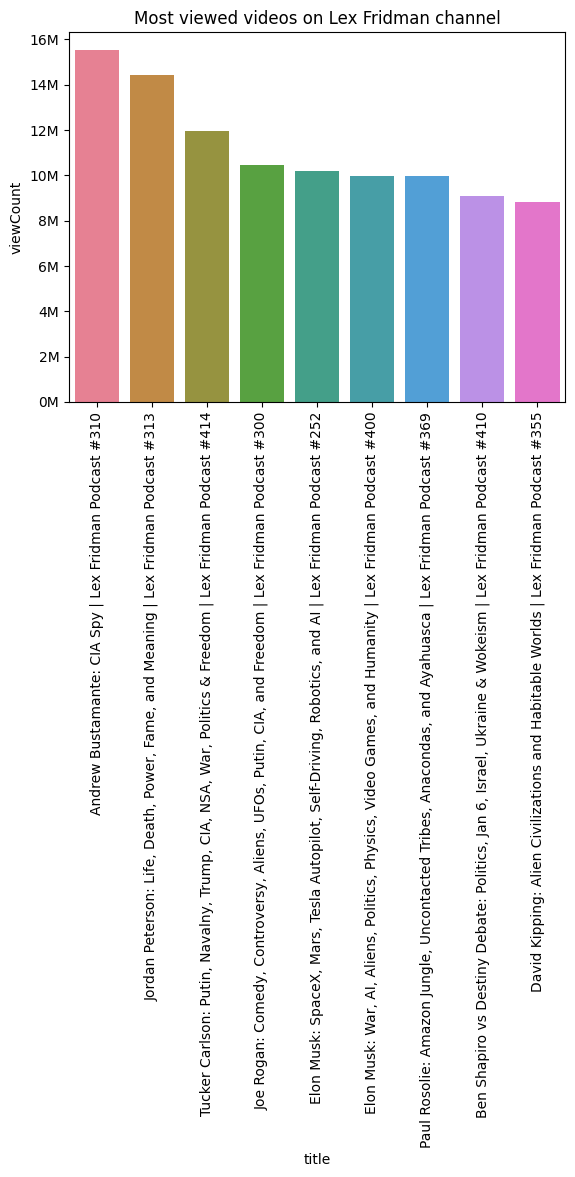

In [149]:
ax = sns.barplot(x='title', y='viewCount', data=video_df.sort_values('viewCount', ascending=False)[0:9], palette=colors)
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}M'.format(x/1000000)))

plt.title('Most viewed videos on Lex Fridman channel')
plt.show()

C:\Users\Alser\AppData\Local\Temp\ipykernel_11252\2764148891.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='title', y='viewCount', data=video_df.sort_values('viewCount', ascending=True)[0:9], palette=colors)
C:\Users\Alser\AppData\Local\Temp\ipykernel_11252\2764148891.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


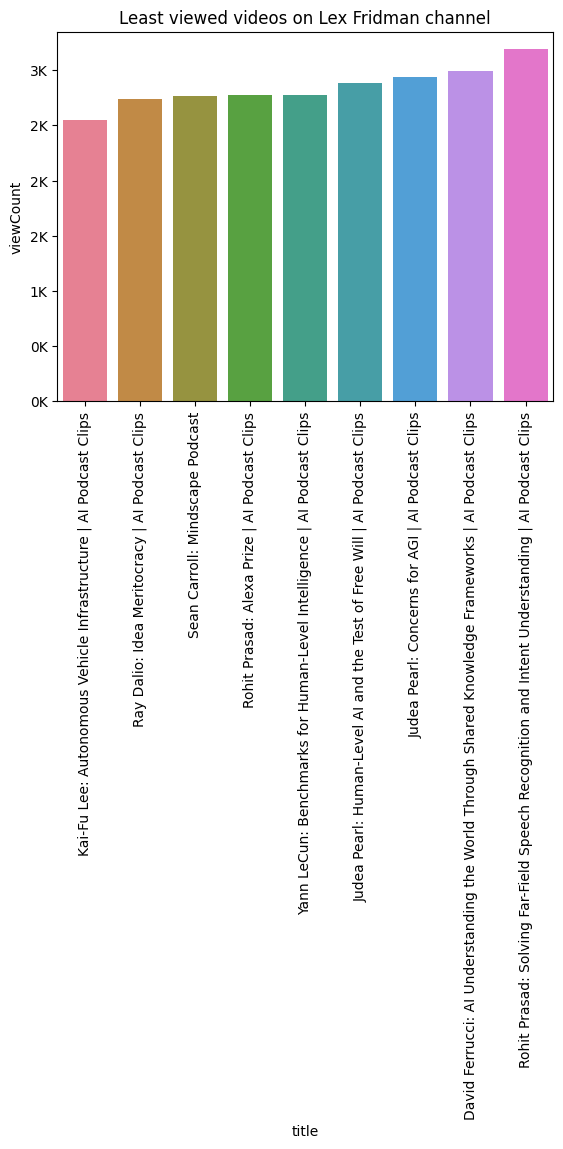

In [148]:
ax = sns.barplot(x='title', y='viewCount', data=video_df.sort_values('viewCount', ascending=True)[0:9], palette=colors)
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}K'.format(x/1000)))

plt.title('Least viewed videos on Lex Fridman channel')
plt.show()

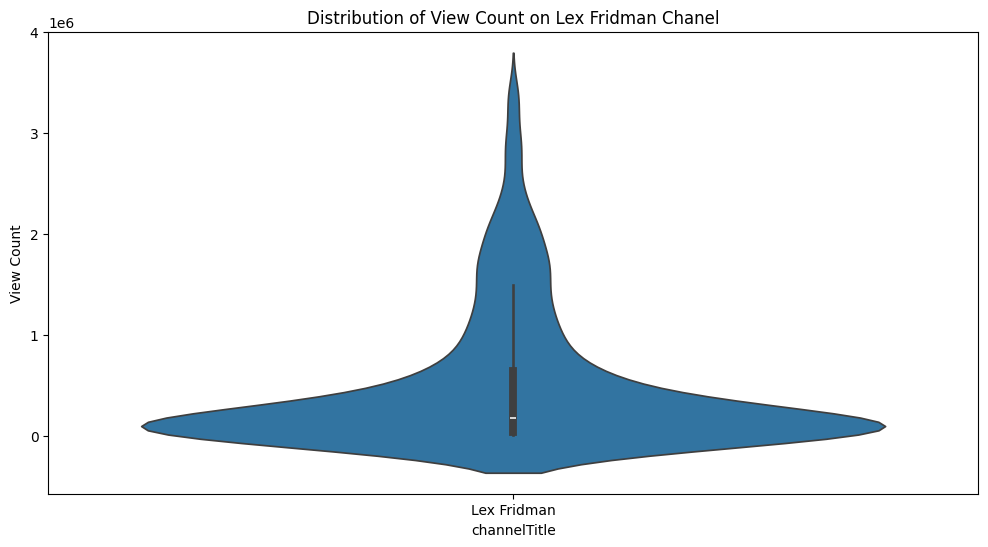

In [32]:
# Filter out outliers if needed
filtered_df = video_df[video_df['viewCount'] < video_df['viewCount'].quantile(0.95)]

# Create a violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='channelTitle', y='viewCount', data=filtered_df)
plt.ylabel('View Count')
plt.title('Distribution of View Count on Lex Fridman Chanel')
plt.show()

## Views vs Likes and Comments

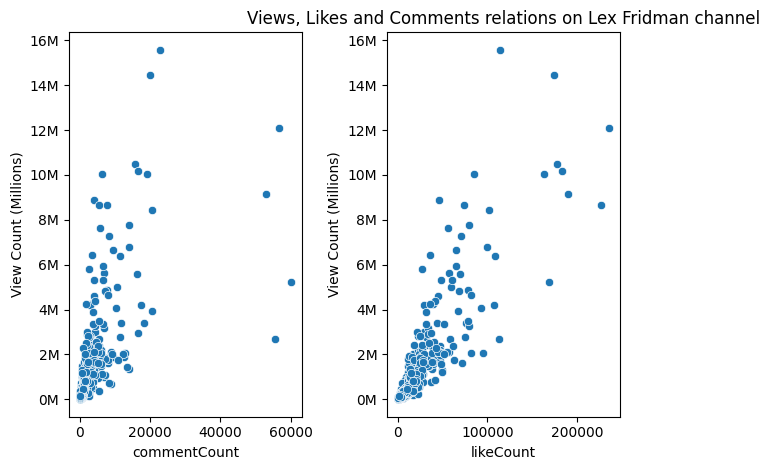

In [34]:
def millions_formatter(x, pos):
    return '{:.0f}M'.format(x / 1e6)

fig, ax = plt.subplots(1, 2)
# Scatter plot for commentCount vs viewCount
sns.scatterplot(data=video_df, x="commentCount", y="viewCount", ax=ax[0])
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
ax[0].set_ylabel('View Count (Millions)')

# Scatter plot for likeCount vs viewCount
sns.scatterplot(data=video_df, x="likeCount", y="viewCount", ax=ax[1])
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
ax[1].set_ylabel('View Count (Millions)')

plt.title('Views, Likes and Comments relations on Lex Fridman channel')
plt.tight_layout()
plt.show()

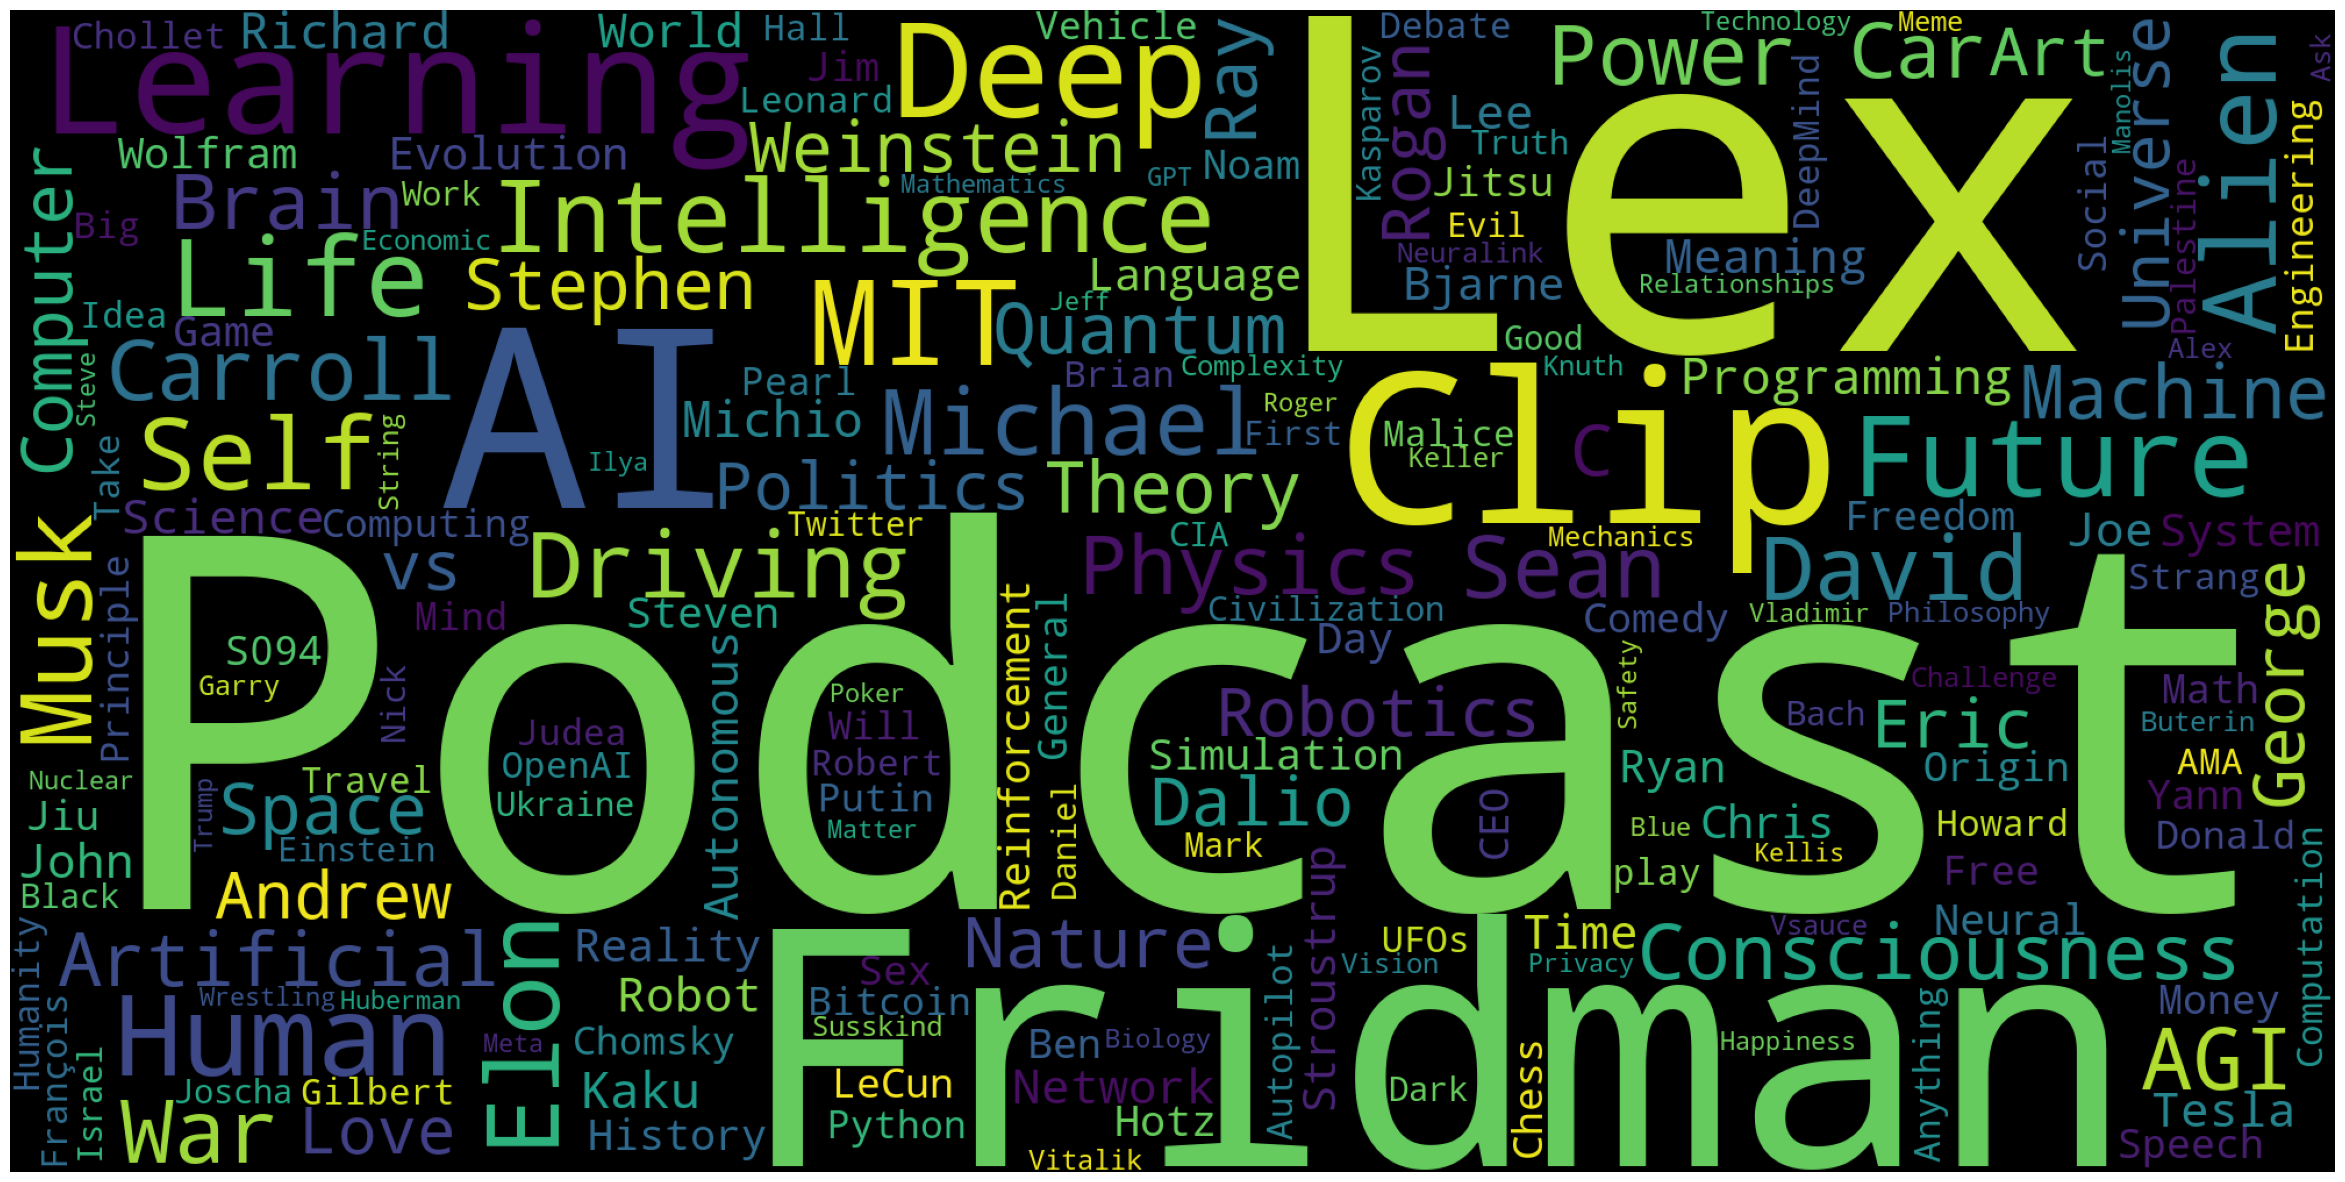

In [37]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)